In [1]:
#Code to connect your google drive with google colaboratory
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install d2l
!pip install matplotlib==3.1.3
!pip install matplotlib_inline 

In [3]:
import os
import torch
import torch
import torchvision
from torch import nn
from torch.utils.data import (DataLoader, Dataset)
from d2l import torch as d2l
import torchvision.transforms as transforms 
import numpy as np
import cv2 as cv

In [ ]:
#Prepare the dataset

#train dataset


trainImagePath = []

positiveTrainingExamples = '/content/drive/MyDrive/MPAssignment/Data/CoralImageClassification/train/ImagesLabelledPositive'

for filename in os.listdir(positiveTrainingExamples):
  if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpg"):
    trainImagePath.append([os.path.join(positiveTrainingExamples, filename),1],)





negativeTrainingExamples = '/content/drive/MyDrive/MPAssignment/Data/CoralImageClassification/train/ImagesLabelledNegative'

for filename in os.listdir(negativeTrainingExamples):
  if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpg"):
    trainImagePath.append([os.path.join(negativeTrainingExamples, filename),0],)

for path in trainImagePath:
  print(path[0],path[1])


#val dataset


valImagePath = []

positiveTrainingExamples = '/content/drive/MyDrive/MPAssignment/Data/CoralImageClassification/val/ImagesLabelledPositive'

for filename in os.listdir(positiveTrainingExamples):
  if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpg"):
    valImagePath.append([os.path.join(positiveTrainingExamples, filename),1],)


negativeTrainingExamples = '/content/drive/MyDrive/MPAssignment/Data/CoralImageClassification/val/ImagesLabelledNegative'

for filename in os.listdir(negativeTrainingExamples):
  if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpg"):
    valImagePath.append([os.path.join(negativeTrainingExamples, filename),0],)



trainImagePath = np.array(trainImagePath)
valImagePath = np.array(valImagePath)


In [5]:
# Hyperparameters
num_classes = 2
learning_rate = 0.001
batch_size = 16
num_epochs = 10
num_folds = 3

In [6]:
class CoralDataset(Dataset):
  def __init__(self, data, root_dir , transform=None):
    self.data = data
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    img_path = self.data[index, 0] 
    image = cv.imread(img_path)
    #print(self.data[index, 1])

    y_label = torch.tensor(int(self.data[index, 1]))

    if self.transform:
      image = self.transform(image)
    
    return(image, y_label)

In [39]:
# z-scale the data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # also scales to [0, 1]
    normalize
])


In [8]:
#create dataset
train_dataset = CoralDataset(data = trainImagePath, root_dir="", transform = preprocess)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)

val_dataset = CoralDataset(data = valImagePath, root_dir="", transform = preprocess)

val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=True)


In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [11]:
#from D2L book
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [12]:
#from D2L book
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""

    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.041, train acc 0.988, test acc 0.998
263.9 examples/sec on cuda


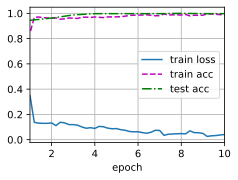

In [13]:
#run train method
train_ch6(finetune_net, train_loader, val_loader, num_epochs, learning_rate, device)

In [36]:
positiveTestingImagePath = []

positiveTrainingExamples = 'drive/MyDrive/MPAssignment/Testing Data_withLabels/CoralImageClassification/Coral Images'

for filename in os.listdir(positiveTrainingExamples):
  if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpg"):
    positiveTestingImagePath.append(os.path.join(positiveTrainingExamples, filename))

positiveTestingImagePath.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

negativeTestingImagePath = []

negativeTrainingExamples = 'drive/MyDrive/MPAssignment/Testing Data_withLabels/CoralImageClassification/Non-Coral Images'

for filename in os.listdir(negativeTrainingExamples):
  if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpg"):
    negativeTestingImagePath .append(os.path.join(negativeTrainingExamples, filename))

negativeTestingImagePath .sort(key=lambda f: int(''.join(filter(str.isdigit, f))))


testingImagePath = []

for path in positiveTestingImagePath:
  testingImagePath.append([path,1])

for path in negativeTestingImagePath:
  testingImagePath.append([path,0])


testingImagePath = np.array(testingImagePath)


In [40]:
test_dataset = CoralDataset(data = testingImagePath, root_dir="", transform = preprocess)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=True)

loss 0.031, train acc 0.990, test acc 1.000
329.6 examples/sec on cuda


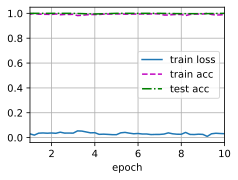

In [41]:
#run train method
train_ch6(finetune_net, train_loader, test_loader, num_epochs, learning_rate, device)